## Importamos librerías

In [2]:
import math
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy.io import arff


In [3]:
tra, trameta = arff.loadarff('/home/sebacastillo/ealab/data/leukemia_train_38x7129.arff')
tst, tstmeta = arff.loadarff('/home/sebacastillo/ealab/data/leukemia_test_34x7129.arff')



In [5]:
train.groupby('CLASS').agg(pl.count())

CLASS,count
str,u32
"""AML""",11
"""ALL""",27


In [7]:
print(train.shape), print(test.shape)

(38, 7130)
(34, 7130)


(None, None)

# PARTICIONO LOS DATOS

# Leemos los datasets

In [8]:
TRAIN = train
TEST = test

# Normalizamos los datos

In [9]:

TRAIN = TRAIN.to_numpy()
TEST = TEST.to_numpy()

X_TRAIN = TRAIN[:,:-1]
y_train = TRAIN[:,-1]
y_train = np.where(np.array(y_train) == 'ALL', 1, 0).astype('int64')
X_TEST = TEST[:,:-1]
y_test = TEST[:,-1]
y_test = np.where(np.array(y_test) == 'ALL', 1, 0).astype('int64')
scaler.fit(X_TRAIN)
Xtrain = scaler.transform(X_TRAIN)
Xtest = scaler.transform(X_TEST)


In [10]:
print(y_train)
print(y_test)

[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0
 0]
[1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 1 1 1 1 1 1]


## Funciones auxiliares

In [11]:
#=================================
def bin(p=0.9):
    '''
    Esta función genera un bit al azar.
    '''
    if random.random() < p:
        return 1
    else:
        return 0
#=================================


#=================================
def fitness(features, Xtrain, Xtest, y_train, y_test):
    '''
    Función de aptitud empleada por nuestro algoritmo.
    '''
    if not isinstance(features, np.ndarray):
        features = np.array(features)

    if not isinstance(features[0], bool):
        features = features.astype(bool)
    
    X_train = Xtrain[:,features]
    X_test = Xtest[:,features]
    
    mlp = MLPClassifier(hidden_layer_sizes=(5,3),
                        activation='tanh',
                        solver='adam',
                        alpha=0.0001,
                        learning_rate_init=0.001,
                        shuffle=True,
                        momentum=0.9,
                        validation_fraction=0.2,
                        n_iter_no_change=10,
                        random_state=42,
                        max_iter=3000).fit(X_train, y_train)

    yp = mlp.predict(X_test)

    acc = (y_test == yp).sum()/len(y_test)

    n_genes = 1 - (features.sum() / len(features))

    alpha = 0.5
    f = (alpha*acc + (1-alpha)*n_genes)
    
    return f, acc, n_genes
#=================================

    
#=================================
def mutation(ind, p):
    '''
    Esta función recorre el cromosoma y evalúa, para cada gen,
    si debe aplicar el operador de mutación.
    '''
    return [abs(i-1) if random.random() < p else i for i in ind]
#=================================

## Inicializamos parámetros del experimento

In [14]:
IND_SIZE = Xtrain.shape[1]  # Cantidad de genes en el cromosoma

POP_SIZE = 100  # Cantidad de individuos en la población
PM = 20./IND_SIZE  # Probabilidad de mutación [aproximadamente 1 gen por cromosoma]
#                   Experimento 4: con mayor probabilidad de mutación.
# PM = 20./IND_SIZE __experimento 2 mejoró el fitness y acc en la segunda generación pero luego se estancó
PX = 0.75  # Probabilidad de cruza
# PX = 0.85  # Probabilidad de cruza
GMAX = 10  # Cantidad máxima de generaciones que se ejecutará el algoritmo

In [15]:
print(IND_SIZE)
print(POP_SIZE)
print(PM)
print(PX)
print(GMAX)

7129
100
0.0028054425585636133
0.75
10


## Creamos los componentes del algoritmo

**Documentación**: https://deap.readthedocs.io/en/master/api/creator.html

In [16]:
# CREAMOS LA FUNCION DE FITNESS
# Esta función tiene "1 OBJETIVO" a "MAXIMIZAR"
creator.create("Fitness",  # Nombre con el que se registra el componente
               base.Fitness,  # Clase de la que hereda
               weights=(1.0,)) 

#---------------------

# CREAMOS EL CONSTRUCTOR DE INDIVIDUOS
creator.create("Individual", # Nombre con el que se registra el componente
               list,  # Clase de la que hereda [Tipo de contenedor en este caso]
               fitness=creator.Fitness,
               acc=0,
               ngenes=0)  # Asignamos un método para evaluar el fitness del individuo

## REGISTRAMOS COMPONENTES

In [17]:
toolbox = base.Toolbox()

#---------------------

# DEFINIMOS COMO CONSTRUIR UN GEN
# el algoritmo retenie la historia de fitnes de genes activos, contribuyendo !!!IMPORTANTE
# a la selección de las variables que contribuyen a mejorar el fitness
toolbox.register("attribute",  # Nombre con el que se registra el componente
                 bin,
                 p=0.1)
                        # Probabilidad de un "1":   exp1:0.1 =ELITE -- Fitness: 0.9513 -- NGENES: 694 -- Acc: 1.0
                        #                           exp2:0.2 =ELITE -- Fitness: 0.8885 -- NGENES: 1380 -- Acc: 0.9706
                        #                           exp3:0.05=ELITE -- Fitness: 0.9595 -- NGENES: 368 -- Acc: 0.9706
                     #                              exp5:0.05 + 20/caracteristicas mutacion: ELITE -- Fitness: 0.9757 -- NGENES: 346 -- Acc: 1.0
#---------------------

# DEFINIMOS COMO CONSTRUIR UN INDIVIDUO/CROMOSOMA
toolbox.register("individual",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 creator.Individual,  # ...
                 toolbox.attribute,  # Función para construir cada gen
                 n=IND_SIZE)  # Número de genes del cromosoma/individuo (se repetirá la función construir gen)

#---------------------

# DEFINIMOS COMO CONSTRUIR LA POBLACION
toolbox.register("population",  # Nombre con el que se registra el componente
                 tools.initRepeat,  # Método usado para construir el cromosoma
                 list,
                 toolbox.individual)

#---------------------

# DEFINIMOS COMO REALIZAR LA CRUZA
toolbox.register("mate",  # Nombre con el que se registra el componente
                 tools.cxTwoPoint)  # 

#---------------------

# DEFINIMOS COMO REALIZAR LA MUTACION
toolbox.register("mutate",  # Nombre con el que se registra el componente
                 mutation,  # Método de mutación (definido como función más arriba)
                 p=PM)  # Parámetro que usa la mutación

#toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
#toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1, indpb=0.2)

#---------------------

# DEFINIMOS COMO REALIZAR LA SELECCION DE INDIVIDUOS
toolbox.register("select",  # Nombre con el que se registra el componente
                 tools.selTournament,  # Método usado para selección [selRoulette | selTournament | ...]
                 tournsize=5)  # Parámetro que usa el torneo

## Definimos las estadísticas a calcular

In [18]:
# EXTRAEMOS EL FITNESS DE TODOS LOS INDIVIDUOS
stats_fit = tools.Statistics(key=lambda ind: ind.fitness.values[0])

# EXTRAEMOS EL ACC DE TODOS LOS INDIVIDUOS
stats_acc = tools.Statistics(key=lambda ind: ind.acc)

# EXTRAEMOS LA FRACCION DE GENES ACTIVOS DE TODOS LOS INDIVIDUOS
stats_frac_active_genes = tools.Statistics(key=lambda ind: ind.ngenes)

# EXTRAEMOS EL NUMERO DE GENES ACTIVOS DE TODOS LOS INDIVIDUOS
stats_active_genes = tools.Statistics(key=lambda ind: np.sum(ind))

mstats = tools.MultiStatistics(fitness=stats_fit,
                               acc=stats_acc,
                               frac_ngenes=stats_frac_active_genes,
                               ngenes=stats_active_genes)

mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

# INICIALIZAMOS UN LOGGER
logbook = tools.Logbook()

# Corremos el modelo con todas las features

In [19]:
f = fitness(np.ones(Xtrain.shape[1]), Xtrain, Xtest, y_train, y_test)

print(f'FITNESS: {f[0]:.4} -- NGENES: {int(Xtrain.shape[1])} -- Acc: {f[1]:.4}\n')

FITNESS: 0.4559 -- NGENES: 7129 -- Acc: 0.9118



In [20]:
#================================================
# INICIALIZAMOS LA POBLACIÓN
#================================================
pop = toolbox.population(n=POP_SIZE)  # Inicializamos una población
#================================================


#================================================
# EVALUAMOS EL FITNESS DE LA POBLACION
#======================================
#fitnesses = list(map(toolbox.evaluate, pop))
fitnesses = Parallel(n_jobs=4, backend='multiprocessing')(delayed(fitness)(ind, Xtrain, Xtest, y_train, y_test) for ind in pop)
#================================================


#================================================
# ASIGNAMOS A CADA INDIVIDUO SU FITNESS
#========================================
for ind,fit in zip(pop, fitnesses):
    ind.fitness.values = (fit[0],)  # Guardamos el fitness para cada individuo (en el individuo)
    ind.acc = fit[1]
    ind.ngenes = fit[2]
#================================================

records = mstats.compile(pop)
logbook.record(gen=0, **records)

In [21]:
#################################################################################
# COMENZAMOS LA EVOLUCION
################################

for g in range(1,GMAX):#tqdm(range(GMAX)):

    #================================================
    # SELECCIONAMOS INDIVIDUO ELITE
    #================================
    idx_elite = np.argmax(fitnesses, axis=0)[0]  # Si maximizamos, hay que usar ".argmax()". El indiv. con mejor fitness
    elite = toolbox.clone(pop[idx_elite])
    del elite.fitness.values, elite.acc, elite.ngenes
    #================================================

    
    #================================================
    # HACEMOS UNA COPIA DE LA POBLACION ACTUAL
    #==========================================
    parents = toolbox.select(pop, POP_SIZE)  # Seleccionamos individuos para alcanzar
                                               # el tamaño de la población
    
    offspring = list(map(toolbox.clone, pop))  # Clonamos para tener nuevos individuos
                                                     # (contenedores independientes)
    #============================================
    
    # REALIZAMOS LA CRUZA DE LOS PADRES
    #====================================
    for i in range(POP_SIZE//2):
        parent1 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        parent2 = toolbox.clone(parents[random.randint(0,POP_SIZE-1)])
        
        if random.random() < PX:
            childs = toolbox.mate(parent1, parent2)
        else:
            childs = (parent1, parent2)
        
        offspring[2*i] = childs[0]
        offspring[2*i+1] = childs[1]


    #================================================
    # MUTAMOS LOS HIJOS
    #=================================
    for mutant in offspring:
        toolbox.mutate(mutant)
        del mutant.fitness.values  #, mutant.acc, mutant.ngenes
    #================================================
    
    
    #================================================
    # EVALUAMOS EL FITNESS
    # Y SE LO ASIGNAMOS A CADA INDIVIDUO
    #======================================
    offspring[0] = elite
    
    fitnesses = Parallel(n_jobs=4, backend='multiprocessing')(delayed(fitness)(ind, Xtrain, Xtest, y_train, y_test) for ind in offspring)

    for ind, fit in zip(offspring, fitnesses):
        ind.fitness.values = (fit[0],)  # Guardamos el fitness para cada individuo (en el individuo)
        ind.acc = fit[1]
        ind.ngenes = fit[2]
    #================================================

    
    #================================================
    # CONSTRUIMOS LA NUEVA POBLACION
    #================================
    pop = toolbox.clone(offspring)
    #================================================

    
    #================================================
    # CALCULAMOS ESTADÏSTICAS
    #============================
    records = mstats.compile(pop)
    logbook.record(gen=g, **records)

    if (g%1 == 0):
        print('='*79)
        print(f'GENERATION: {g}')
        print(f'ELITE -- Fitness: {elite.fitness.values[0]:.4} -- NGENES: {np.sum(elite)} -- Acc: {elite.acc:.4}')
        print('FITNES: ', records['fitness'])
        print('ACC: ', records['acc'])
        print('GENES: ', records['ngenes'])
    #================================================

GENERATION: 1
ELITE -- Fitness: 0.9507 -- NGENES: 703 -- Acc: 1.0
FITNES:  {'avg': 0.8889107250418753, 'std': 0.027538381254255312, 'min': 0.8168685485135281, 'max': 0.9506943470332445}
ACC:  {'avg': 0.8773529411764704, 'std': 0.05471774065025449, 'min': 0.7352941176470589, 'max': 1.0}
GENES:  {'avg': 709.56, 'std': 27.031581529758853, 'min': 648, 'max': 777}
GENERATION: 2
ELITE -- Fitness: 0.9507 -- NGENES: 703 -- Acc: 1.0
FITNES:  {'avg': 0.8984821524345463, 'std': 0.02853152390711746, 'min': 0.8217079369270502, 'max': 0.9506943470332445}
ACC:  {'avg': 0.8955882352941176, 'std': 0.057841060115579816, 'min': 0.7352941176470589, 'max': 1.0}
GENES:  {'avg': 703.09, 'std': 27.130460740650907, 'min': 645, 'max': 763}
GENERATION: 3
ELITE -- Fitness: 0.9507 -- NGENES: 703 -- Acc: 1.0
FITNES:  {'avg': 0.9113562251945244, 'std': 0.026323751720304774, 'min': 0.8351513701286377, 'max': 0.9506943470332445}
ACC:  {'avg': 0.9211764705882354, 'std': 0.052921564995023464, 'min': 0.7647058823529411, 

## Graficamos la evolución del fitness

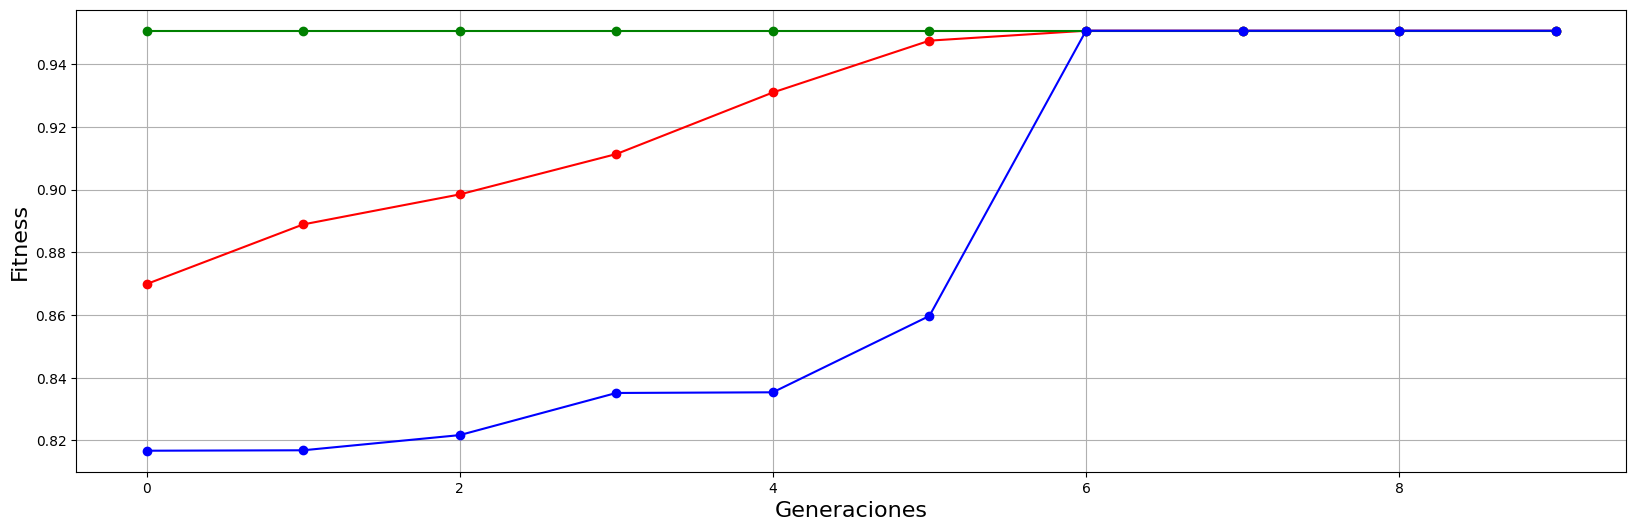

In [22]:
f_avg = logbook.chapters['fitness'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
f_max = logbook.chapters['fitness'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
f_min = logbook.chapters['fitness'].select('min')  # Extraemos fitness mínimo a lo largo de las épocas

N = 30 if GMAX > 200 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-or')
ax.plot(range(N), f_max[:N], '-og')
ax.plot(range(N), f_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Fitness', fontsize=16)
ax.grid(True)

## Graficamos la evolución del accuracy

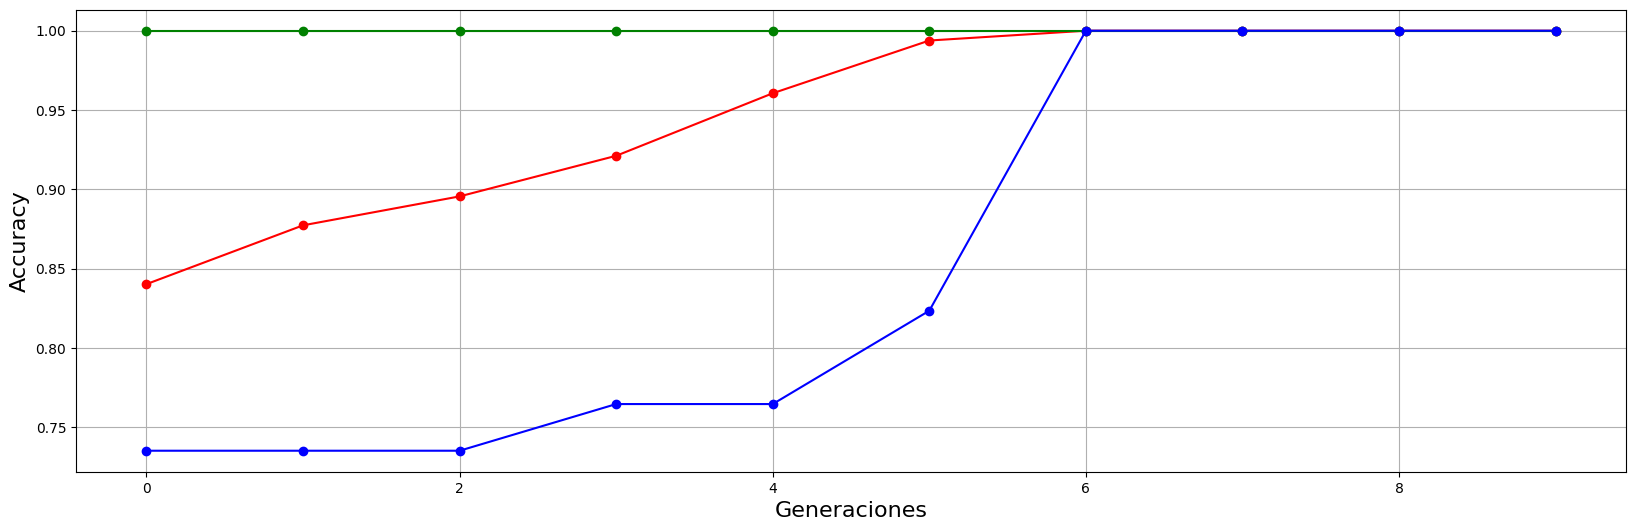

In [23]:
f_avg = logbook.chapters['acc'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
f_max = logbook.chapters['acc'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
f_min = logbook.chapters['acc'].select('min')  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 30 if GMAX > 200 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), f_avg[:N], '-or')
ax.plot(range(N), f_max[:N], '-og')
ax.plot(range(N), f_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Accuracy', fontsize=16)
ax.grid(True)

## Graficamos la evolución del número de genes

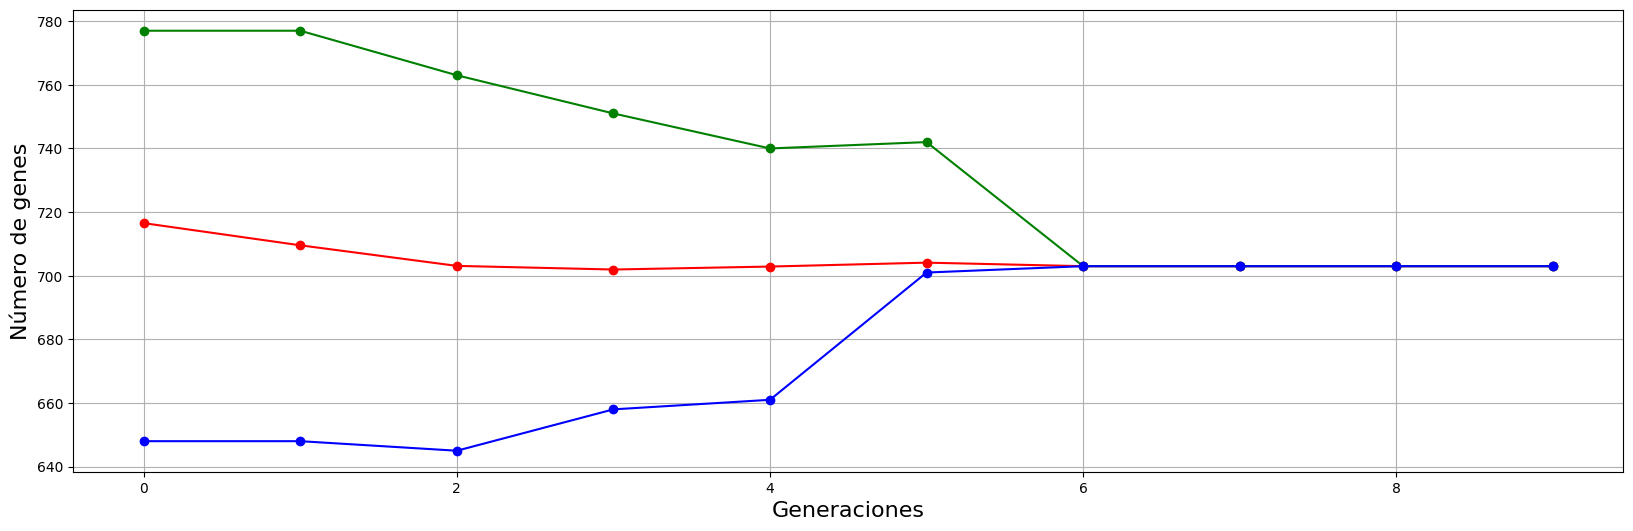

In [24]:
ngenes_avg = logbook.chapters['ngenes'].select('avg')  # Extraemos fitness promedio a lo largo de las épocas
ngenes_max = logbook.chapters['ngenes'].select('max')  # Extraemos fitness máximo a lo largo de las épocas
ngenes_min = logbook.chapters['ngenes'].select('min')  # Extraemos fitness mínimo (elite) a lo largo de las épocas

N = 100 if GMAX > 2000 else GMAX 
fig, ax = plt.subplots(1, 1, figsize=(20,6)) 
ax.plot(range(N), ngenes_avg[:N], '-or')
ax.plot(range(N), ngenes_max[:N], '-og')
ax.plot(range(N), ngenes_min[:N], '-ob')
ax.set_xlabel('Generaciones', fontsize=16)
ax.set_ylabel('Número de genes', fontsize=16)
ax.grid(True)